In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Image center position: (92, 92)
Center pixel value (RGB): [172  92  67]
Center pixel value after patch (should be patch color): [ 50 158 168]


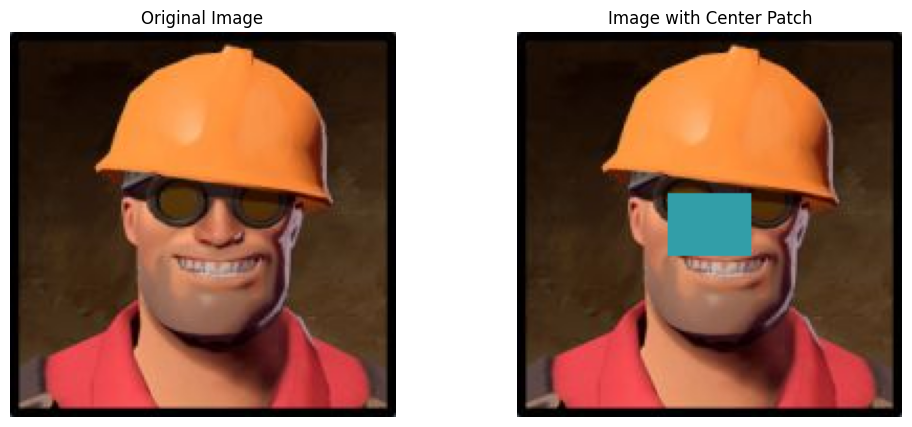

In [18]:
source_img = cv2.imread('images/tf2_engineer.jpg')
rgb_img = cv2.cvtColor(source_img, cv2.COLOR_BGR2RGB)

center = (rgb_img.shape[0] // 2, rgb_img.shape[1] // 2)
print("Image center position:", center)
print("Center pixel value (RGB):", rgb_img[center[0], center[1]])

half_height, half_width = 15, 20
start_row = center[0] - half_height
end_row = center[0] + half_height
start_col = center[1] - half_width
end_col = center[1] + half_width

hex_color = "#329ea8"
patch_rgb = np.array([int(hex_color[i:i+2], 16) for i in (1, 3, 5)])

patched_img = rgb_img.copy()
patched_img[start_row:end_row, start_col:end_col, :] = patch_rgb

patch_center_pixel = patched_img[center[0], center[1]]
print("Center pixel value after patch (should be patch color):", patch_center_pixel)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(rgb_img)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(patched_img)
plt.title('Image with Center Patch')
plt.axis('off')
plt.show()

Randomly selected pixels and their original/negative values:
Pixel (91,580): Original=105, Negative=150
Pixel (134,136): Original=114, Negative=141
Pixel (240,387): Original=139, Negative=116
Pixel (604,754): Original=99, Negative=156
Pixel (633,228): Original=114, Negative=141


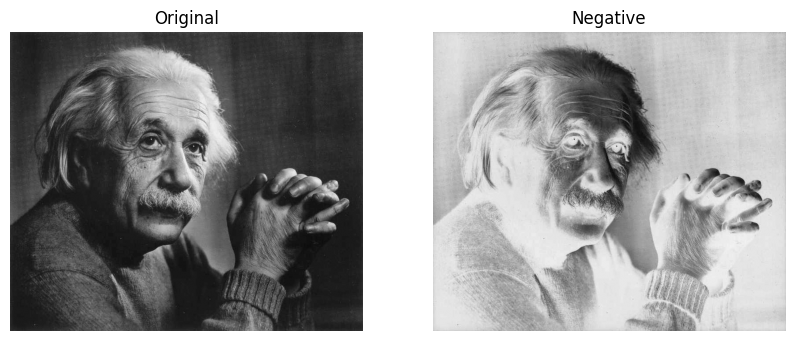

In [19]:
import random
einstein_img = cv2.imread('images/einstein.tif', 0)
negative_img = np.subtract(255, einstein_img)
coords_list = [(y, x) for y in range(einstein_img.shape[0]) for x in range(einstein_img.shape[1])]
random.seed(99)
random.shuffle(coords_list)
chosen_pixels = coords_list[:5]
print("Randomly selected pixels and their original/negative values:")
for y, x in chosen_pixels:
    orig_val = einstein_img[y, x]
    neg_val = negative_img[y, x]
    print(f"Pixel ({y},{x}): Original={orig_val}, Negative={neg_val}")

fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].imshow(einstein_img, cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')
axs[1].imshow(negative_img, cmap='gray')
axs[1].set_title('Negative')
axs[1].axis('off')
plt.show()

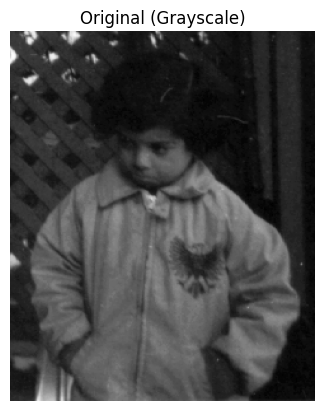

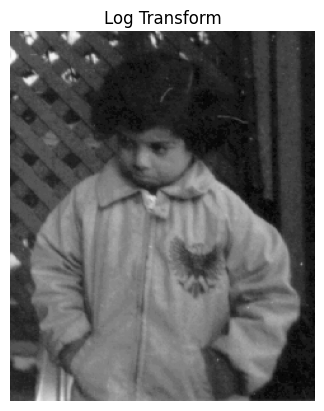

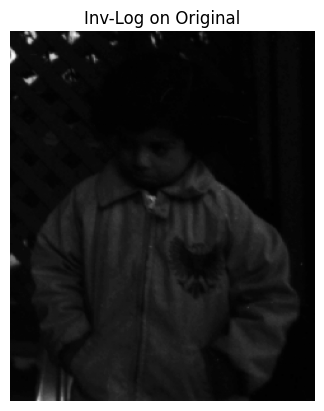

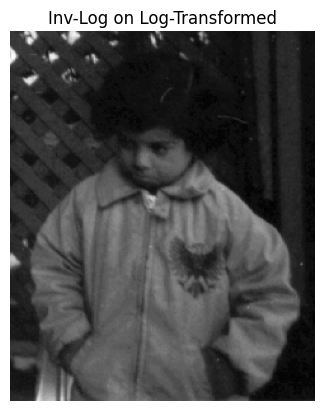

In [20]:
def log_transform(img):
    img = img.astype(np.float64)
    c = 255 / np.log1p(img.max())
    log_img = c * np.log1p(img)
    return np.clip(log_img, 0, 255).astype(np.uint8)

def inv_log_transform(img, c):
    img = img.astype(np.float64)
    inv_img = np.expm1(img / c)
    return np.clip(inv_img, 0, 255).astype(np.uint8)

pout_img = cv2.imread('images/pout.tif', 0)
plt.imshow(pout_img, cmap='gray')
plt.title("Original (Grayscale)")
plt.axis('off')
plt.show()

log_c = 255 / np.log1p(np.max(pout_img))
pout_log = log_transform(pout_img)
plt.imshow(pout_log, cmap='gray')
plt.title("Log Transform")
plt.axis('off')
plt.show()

pout_invlog_orig = inv_log_transform(pout_img, log_c)
plt.imshow(pout_invlog_orig, cmap='gray')
plt.title("Inv-Log on Original")
plt.axis('off')
plt.show()

pout_invlog_onlog = inv_log_transform(pout_log, log_c)
plt.imshow(pout_invlog_onlog, cmap='gray')
plt.title("Inv-Log on Log-Transformed")
plt.axis('off')
plt.show()

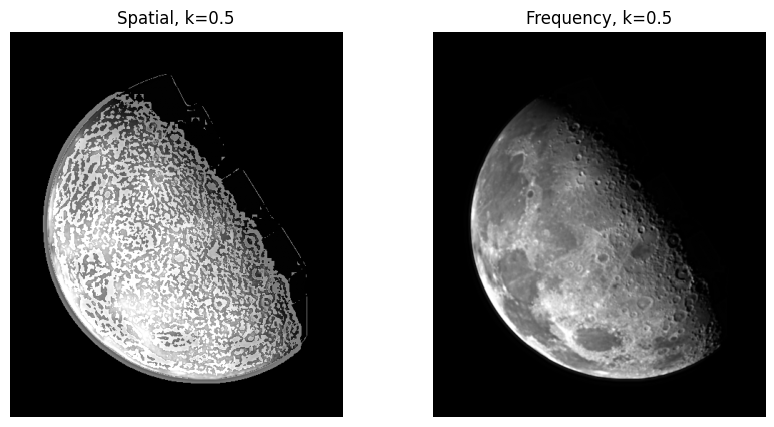

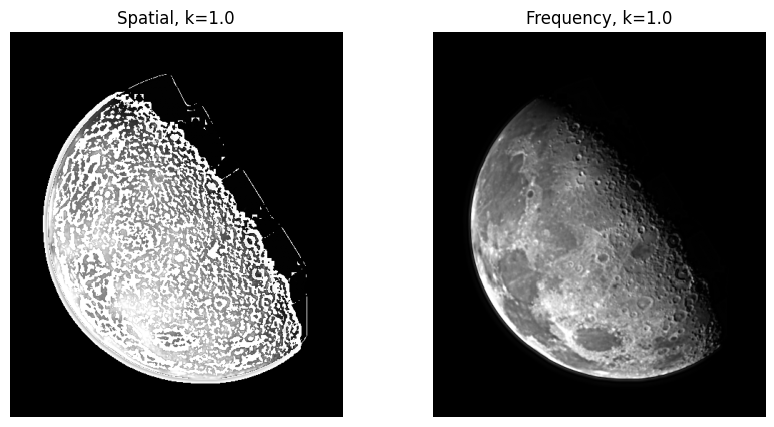

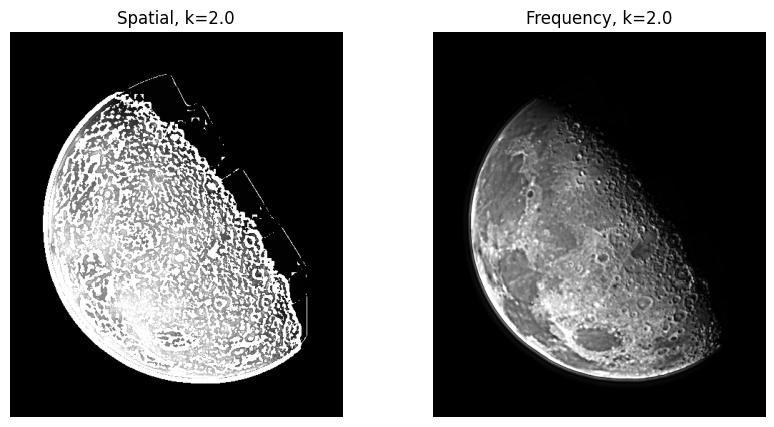

In [21]:
from numpy.fft import fft2, ifft2, fftshift, ifftshift
moon_img = cv2.imread('images/moon.tif', 0)

spatial_sharpened = []
for factor in [0.5, 1.0, 2.0]:

    blurred = cv2.blur(moon_img, (11,11))
    mask = moon_img - blurred
    sharp = np.clip(moon_img + factor * mask, 0, 255).astype(np.uint8)
    spatial_sharpened.append(sharp)

def butterworth_hp(shape, d0, n=2):
    rows, cols = shape
    crow, ccol = rows//2, cols//2
    Y, X = np.ogrid[:rows, :cols]
    D = np.sqrt((Y - crow)**2 + (X - ccol)**2)
    H = 1 / (1 + (d0 / (D+1e-6))**(2*n))
    return H

D0 = 35
H = butterworth_hp(moon_img.shape, D0)

F = fft2(moon_img)
F_shift = fftshift(F)
freq_sharpened = []
for k in [0.5, 1.0, 2.0]:
    filter_ = (1 + k * H)
    sharpened_f = F_shift * filter_
    img_back = np.abs(ifft2(ifftshift(sharpened_f)))
    freq_sharpened.append(np.clip(img_back, 0, 255).astype(np.uint8))

for i, k in enumerate([0.5, 1.0, 2.0]):
    fig, axes = plt.subplots(1,2,figsize=(10,5))
    axes[0].imshow(spatial_sharpened[i], cmap='gray')
    axes[0].set_title(f'Spatial, k={k}')
    axes[0].axis('off')
    axes[1].imshow(freq_sharpened[i], cmap='gray')
    axes[1].set_title(f'Frequency, k={k}')
    axes[1].axis('off')
    plt.show()

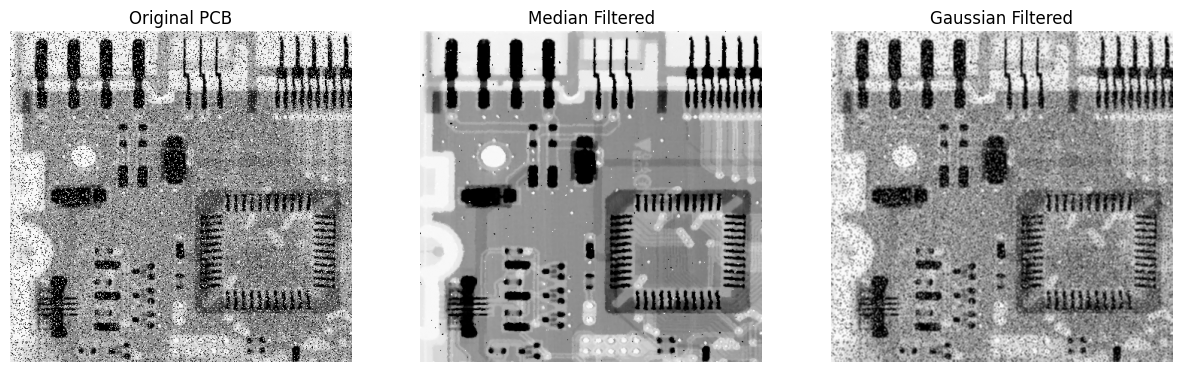

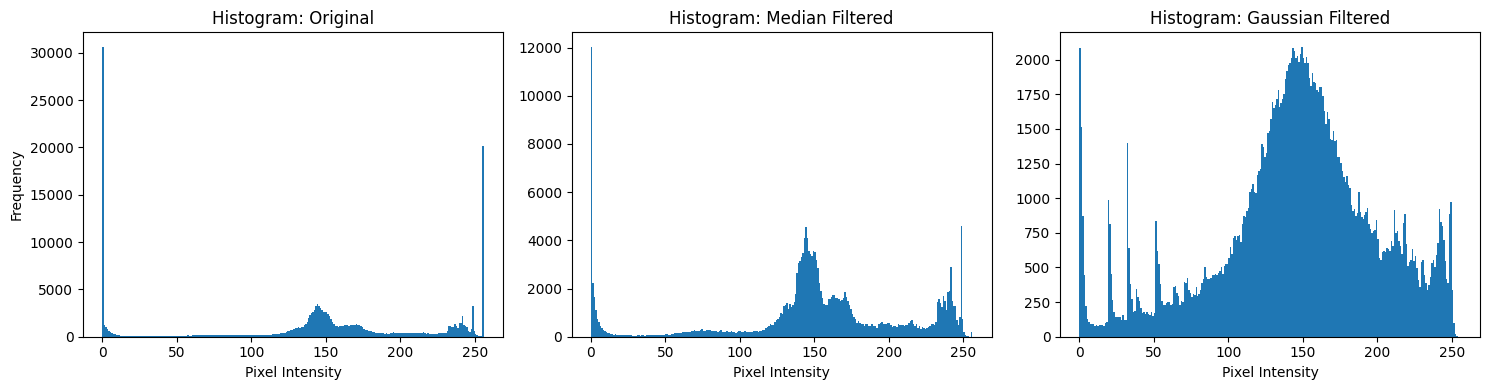

In [22]:
pcb_img = cv2.imread('images/pcb.tif', cv2.IMREAD_GRAYSCALE)
median_filtered = cv2.medianBlur(pcb_img, 3)
gaussian_filtered = cv2.GaussianBlur(pcb_img, (3,3), 1)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(pcb_img, cmap='gray')
plt.title('Original PCB')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(median_filtered, cmap='gray')
plt.title('Median Filtered')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(gaussian_filtered, cmap='gray')
plt.title('Gaussian Filtered')
plt.axis('off')
plt.show()

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.hist(pcb_img.flatten(), bins=256, range=[0,256])
plt.title('Histogram: Original')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.subplot(1,3,2)
plt.hist(median_filtered.flatten(), bins=256, range=[0,256])
plt.title('Histogram: Median Filtered')
plt.xlabel('Pixel Intensity')

plt.subplot(1,3,3)
plt.hist(gaussian_filtered.flatten(), bins=256, range=[0,256])
plt.title('Histogram: Gaussian Filtered')
plt.xlabel('Pixel Intensity')
plt.tight_layout()
plt.show()

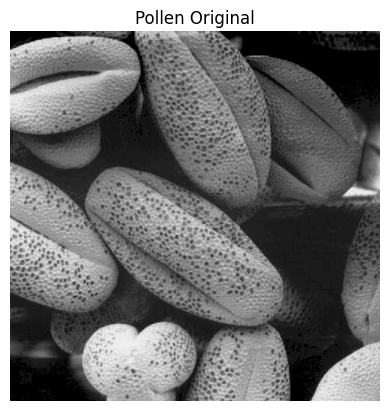

Intensity min: 91, max: 138


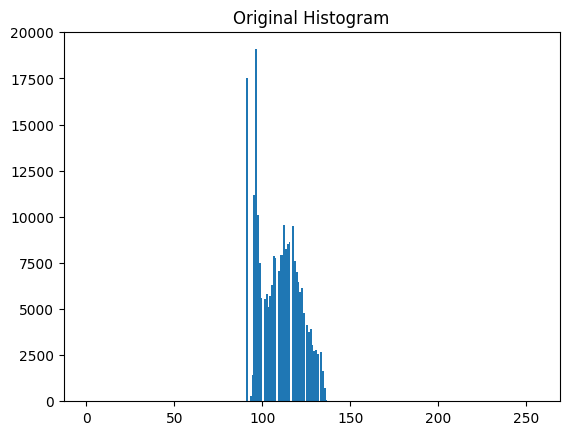

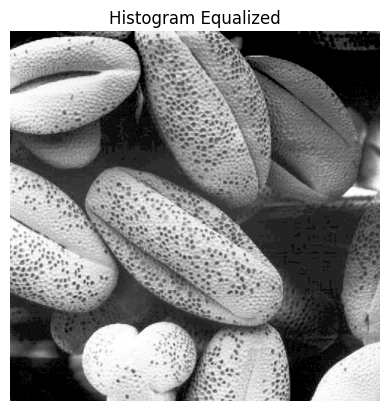

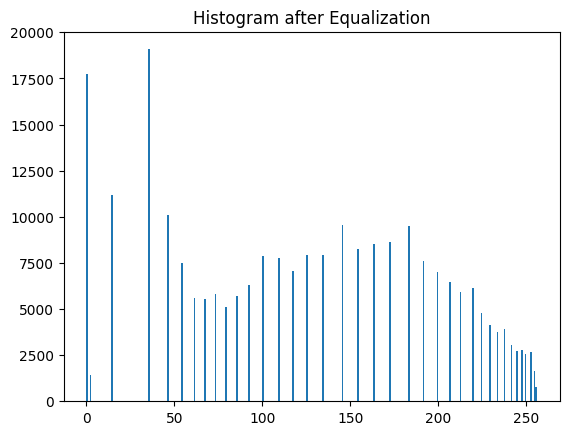

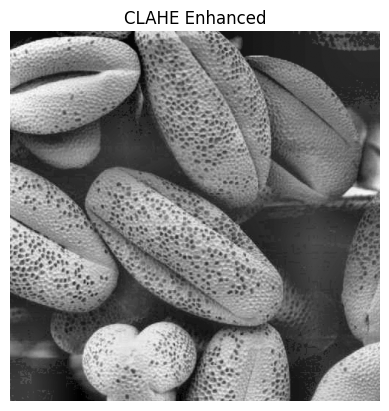

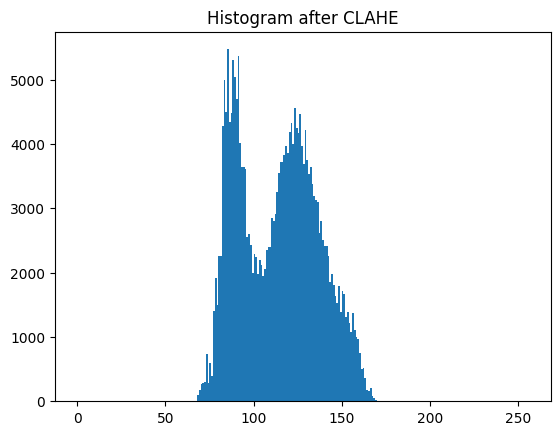

Standard deviation before: 11.49
Std after equalization: 77.39
Std after CLAHE: 22.57


In [23]:
pollen_img = cv2.imread('images/pollen.tif', 0)
plt.figure()
plt.imshow(pollen_img, cmap='gray')
plt.title('Pollen Original')
plt.axis('off')
plt.show()

vals, cnts = np.unique(pollen_img, return_counts=True)
print(f"Intensity min: {pollen_img.min()}, max: {pollen_img.max()}")
plt.figure()
plt.hist(pollen_img.ravel(), bins=256, range=[0,256])
plt.title('Original Histogram')
plt.show()

pollen_eq = cv2.equalizeHist(pollen_img)
plt.figure()
plt.imshow(pollen_eq, cmap='gray')
plt.title('Histogram Equalized')
plt.axis('off')
plt.show()
plt.figure()
plt.hist(pollen_eq.ravel(), bins=256, range=[0,256])
plt.title('Histogram after Equalization')
plt.show()

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
pollen_clahe = clahe.apply(pollen_img)
plt.figure()
plt.imshow(pollen_clahe, cmap='gray')
plt.title('CLAHE Enhanced')
plt.axis('off')
plt.show()
plt.figure()
plt.hist(pollen_clahe.ravel(), bins=256, range=[0,256])
plt.title('Histogram after CLAHE')
plt.show()

print(f"Standard deviation before: {pollen_img.std():.2f}")
print(f"Std after equalization: {pollen_eq.std():.2f}")
print(f"Std after CLAHE: {pollen_clahe.std():.2f}")